[Info] 'Status' has only one class. Creating demo target 'Status2'...

--- A1: Entropy of Target ---
Entropy(Status2): 0.1620

--- A2: Gini Index of Target ---
Gini(Status2): 0.0404
-------------------------------------------------------

--- A3 & A4: Information Gain for Each Feature ---
Site_ID: 0.000000
Gage_Height_ft: 0.155612
Status: 0.000000
Precipitation_in: 0.010978
Reservoir_Storage_acre_ft: 0.157882

Best Root Feature: Reservoir_Storage_acre_ft
-------------------------------------------------------

Selected Features for Medium Tree: ['Reservoir_Storage_acre_ft', 'Gage_Height_ft', 'Precipitation_in']

--- A5: Medium Decision Tree Classifier --
Decision Tree Accuracy (TEST set): 0.9492
Number of leaf nodes: 19
-------------------------------------------------------


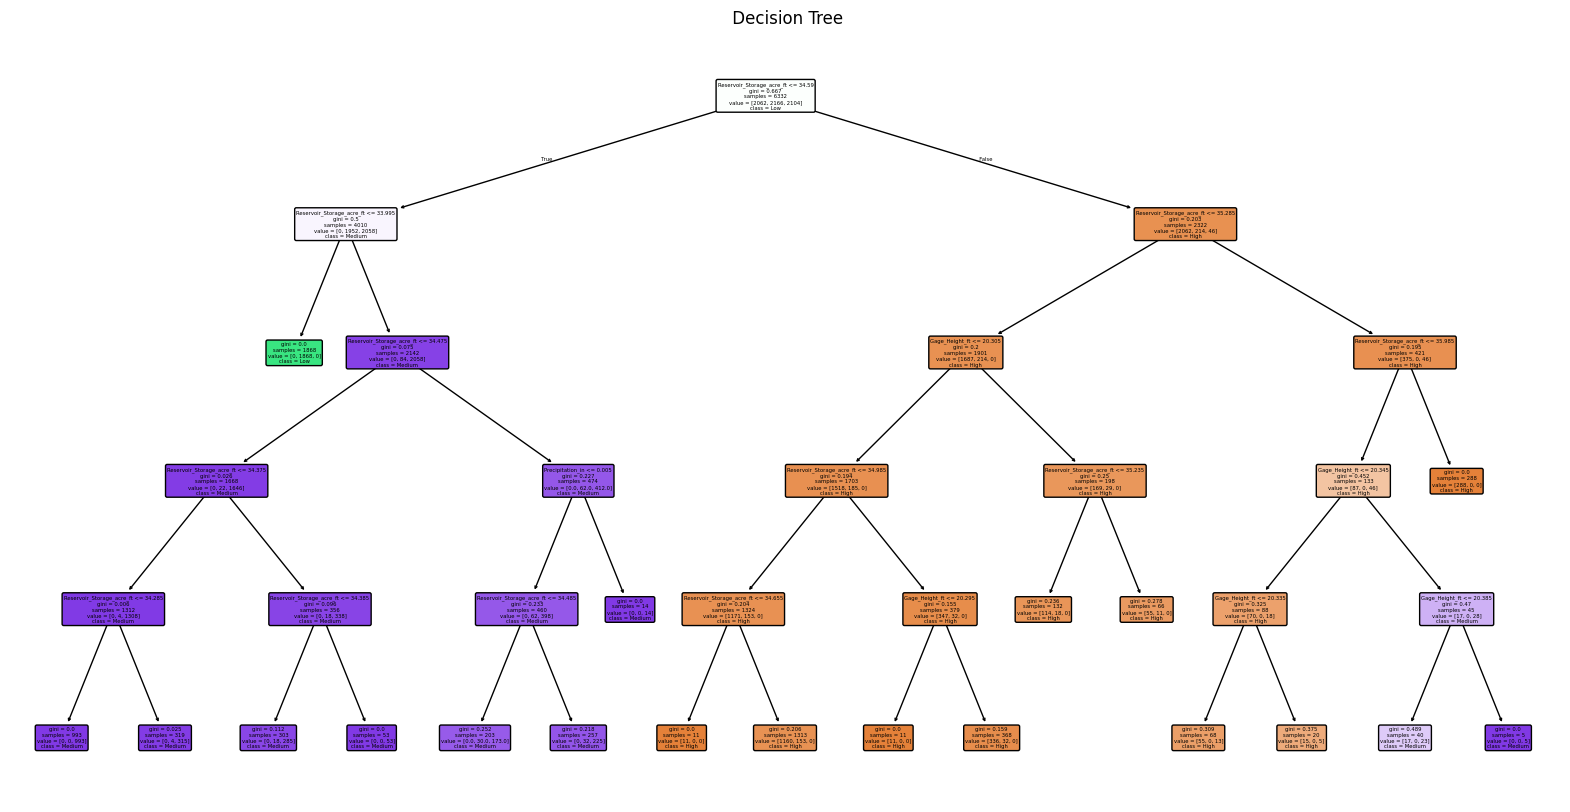

Decision Tree plot is displayed.
-------------------------------------------------------


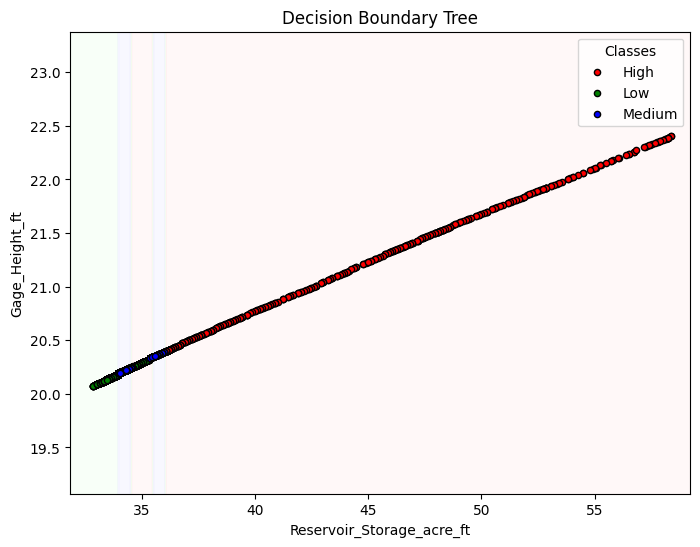

Decision boundary plot is displayed.
-------------------------------------------------------


In [35]:
# ===========================
# Lab 06 — Full Script (A1–A7)
# ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import warnings

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv("merged_clean_dataset (1).csv")

TARGET_COL = "Status"

# If Status has only one class, create demo target
if df[TARGET_COL].nunique() <= 1:
    print("[Info] 'Status' has only one class. Creating demo target 'Status2'...")
    # Create target with bins + randomness to avoid 100% accuracy
    df["Status2"] = pd.cut(
        df["Stream_Flow_cfs"] + np.random.normal(0, 5, size=len(df)),
        bins=3,
        labels=["Low", "Medium", "High"]
    )
    TARGET_COL = "Status2"

df = df.dropna(subset=[TARGET_COL]).copy()

# -----------------------------
# A1: Entropy
# -----------------------------
def entropy(y):
    y = pd.Series(y).dropna()
    n = len(y)
    if n == 0:
        return 0.0
    counts = Counter(y)
    return -sum((c/n) * np.log2(c/n) for c in counts.values())

print("\n--- A1: Entropy of Target ---")
print(f"Entropy({TARGET_COL}): {entropy(df[TARGET_COL]):.4f}")

# -----------------------------
# A2: Gini Index
# -----------------------------
def gini_index(y):
    y = pd.Series(y).dropna()
    n = len(y)
    if n == 0:
        return 0.0
    counts = Counter(y)
    return 1.0 - sum((c / n) ** 2 for c in counts.values())

print("\n--- A2: Gini Index of Target ---")
print(f"Gini({TARGET_COL}): {gini_index(df[TARGET_COL]):.4f}")
print("-------------------------------------------------------")

# -----------------------------
# A3 & A4: Information Gain
# -----------------------------
def information_gain(df_, feature, target=TARGET_COL):
    working = df_[[feature, target]].dropna(subset=[target])
    total_ent = entropy(working[target])
    if total_ent == 0.0:
        return 0.0
    vals, counts = np.unique(working[feature], return_counts=True)
    weighted_ent = 0.0
    N = len(working)
    for v, c in zip(vals, counts):
        subset_t = working.loc[working[feature] == v, target]
        weighted_ent += (c / N) * entropy(subset_t)
    return total_ent - weighted_ent

excluded = {TARGET_COL, "Date", "Time", "Timezone", "Stream_Flow_cfs"}  # exclude Stream_Flow_cfs
features = [c for c in df.columns if c not in excluded]
gains = {f: information_gain(df, f, target=TARGET_COL) for f in features}
root_feature = max(gains, key=gains.get)

print("\n--- A3 & A4: Information Gain for Each Feature ---")
for f, ig in gains.items():
    print(f"{f}: {ig:.6f}")
print(f"\nBest Root Feature: {root_feature}")
print("-------------------------------------------------------")

## -----------------------------
# A5: Slightly Smaller Medium-Sized Decision Tree
# -----------------------------
from sklearn.utils import resample

# --- Step 1: Create a balanced synthetic target ---
df["Target_demo"] = pd.qcut(df["Stream_Flow_cfs"], q=3, labels=["Low", "Medium", "High"])
TARGET_COL = "Target_demo"

# --- Step 2: Select numeric features with sufficient unique values ---
numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
good_features = [c for c in numeric_cols if df[c].nunique() > 5]
top_features = sorted(gains, key=gains.get, reverse=True)[:5]
selected_features = [f for f in top_features if f in good_features]
print("\nSelected Features for Medium Tree:", selected_features)

X = df[selected_features].fillna(0)
y = df[TARGET_COL].astype(str)

# --- Step 3: Optional – balance classes via upsampling ---
counts = y.value_counts()
if counts.min() / counts.max() < 0.5:
    df_bal = pd.concat([X, y], axis=1)
    dfs = [resample(df_bal[df_bal[TARGET_COL] == cls],
                    replace=True,
                    n_samples=counts.max(),
                    random_state=42)
           for cls in counts.index]
    df_balanced = pd.concat(dfs)
    X = df_balanced[selected_features]
    y = df_balanced[TARGET_COL]

# --- Step 4: Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Step 5: Train medium-sized tree (slightly smaller) ---
clf = DecisionTreeClassifier(
    criterion="gini",
    random_state=42,
    max_depth=5,       # medium depth
    min_samples_split=10,  # require at least 10 samples to split
    min_samples_leaf=5      # minimum 5 samples per leaf
)
clf.fit(X_train, y_train)

# --- Step 6: Accuracy & leaf nodes ---
accuracy = clf.score(X_test, y_test)
print("\n--- A5: Medium Decision Tree Classifier --")
print(f"Decision Tree Accuracy (TEST set): {accuracy:.4f}")
print(f"Number of leaf nodes: {clf.get_n_leaves()}")
print("-------------------------------------------------------")

# -----------------------------
# A6: Visualize Decision Tree
# -----------------------------
plt.figure(figsize=(20,10))
plot_tree(
    clf,
    feature_names=selected_features,
    class_names=clf.classes_,
    filled=True,
    rounded=True
)
plt.title(" Decision Tree")
plt.show()
print("Decision Tree plot is displayed.")
print("-------------------------------------------------------")

# -----------------------------
# A7: Decision Boundary (2D view)
# -----------------------------
plot_cols = selected_features[:2]
X_plot = X[plot_cols]

clf2 = DecisionTreeClassifier(
    criterion="gini",
    random_state=42,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5
)
clf2.fit(X_plot, y)

x_min, x_max = X_plot.iloc[:,0].min()-1, X_plot.iloc[:,0].max()+1
y_min, y_max = X_plot.iloc[:,1].min()-1, X_plot.iloc[:,1].max()+1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, (x_max-x_min)/200),
    np.arange(y_min, y_max, (y_max-y_min)/200)
)

grid = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=plot_cols)
Z = clf2.predict(grid)
class_to_int = {c:i for i,c in enumerate(clf2.classes_)}
Z = np.array([class_to_int[z] for z in Z]).reshape(xx.shape)

cmap_light = ListedColormap(["#FFEEEE", "#EEFFEE", "#EEEEFF"])
cmap_bold  = ListedColormap(["red", "green", "blue"])

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)

for class_label, color in zip(clf2.classes_, ["red","green","blue"]):
    idx = y == class_label
    plt.scatter(
        X_plot.loc[idx, plot_cols[0]],
        X_plot.loc[idx, plot_cols[1]],
        c=color,
        edgecolor="k",
        s=20,
        label=class_label
    )

plt.xlabel(plot_cols[0])
plt.ylabel(plot_cols[1])
plt.title("Decision Boundary Tree")
plt.legend(title="Classes")
plt.show()
print("Decision boundary plot is displayed.")
print("-------------------------------------------------------")
